# 9B_vocab_go_terms
12/01/2020

- a. Dot plot of subset of common normal tissue vocabularies ? 
- b.    GO terms of common normal tissue vocabulary connected genes
- c.    Dot plot of a subset of regulatory TF vocabularies across all 17 normal cell types
- d.    Dot plot of common cancer vocabularies
- e.     Common cancer connected vocab genes and/or GO Terms


dot plots in R

In [1]:
import pybedtools
import pandas as pd
import os,glob
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict,Counter
import scipy

In [2]:
%load_ext autoreload

%autoreload 2

# 0. Setup

In [3]:
save_dir = '../data/processed/fig7_vocab_go'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
# tfs 
tf_annon_df = pd.read_csv('../data/external/HOCOMOCOv11_annotation.csv',index_col=0)
tf_annon_df['id_trim'] = tf_annon_df['id'] + '.pwm.trim'
tf_name_to_id_dict = pd.Series(tf_annon_df.id_trim.values, index=tf_annon_df.tf.values).to_dict()
tf_id_to_name_dict = pd.Series(tf_annon_df.tf.values, index=tf_annon_df.id_trim.values).to_dict()

## vocab to gene assignments


In [20]:
%%time
data_type='sum'#comb'
data_all = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
print(data_all.shape)
data_all[:5]

(793952, 534)
CPU times: user 33.3 s, sys: 8.49 s, total: 41.8 s
Wall time: 34 s


,tissue,exp,num_loop_counts,num_loops,num_atac_regions,AHR,ARID5B,ARNT,ARNTL,ATF1,...,NKX6-1,VAX1,ZIC1,HMX1,MAFA,MEOX1,E2F5,ESR2,KLF14,TBX15
A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
data_all.tissue.unique()

array(['A431-CTRLi', 'A431-p63i', 'Airway', 'Astrocytes', 'Bladder',
       'CAL27-CTRLi', 'CAL27-p63i', 'COLO_SCR_DMSO', 'COLO_SCR_PLX',
       'COLO_shMITF_DMSO', 'COLO_shMITF_PLX', 'Colon', 'D0-CTRLi',
       'D0-p63i', 'D3-CTRLi', 'D3-p63i', 'Esophageal', 'GDSD0', 'GDSD3',
       'GDSD6', 'GM12878', 'HMEC', 'Melanocytes', 'Ovarian', 'Pancreas',
       'Prostate', 'Renal', 'SCC13-CTRLi', 'SCC13-p63i', 'Thyroid',
       'Uterine', 'WM_SCR_DMSO'], dtype=object)

In [57]:
%%time
data_type='comb'
data_all_comb = pd.read_csv('../data/processed/tissue_crms/all_count_'+data_type +'_overall.csv',index_col=0,header=0)
print(data_all_comb.shape)
data_all_comb[:5]

(793952, 1063)
CPU times: user 1min 27s, sys: 19.9 s, total: 1min 47s
Wall time: 1min 32s


,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,102.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## vocab words


In [7]:
mpra_lib_df = pd.read_csv('../data/processed/fig4_modelling/vocab_sum_final/for_ld/vocab_instances20_seqs_sel.csv',index_col=0)

mpra_lib_df[:5]

,vocab_pair,tot_dist,btn_dist,chr,start,stop,start_pad,stop_pad,vocab1,vocab1_start,...,vocab2_stop,tissue,loop_type,vocab_tissue_count,name,check_rs,scr_pass_rs,seq_config,seq,name_config
0,BARX2::FOXF2,28,14,chr1,206848337,206848365,206848284,206848418,BARX2,206848337,...,206848365,Colon,pro_pro,1,BARX2::FOXF2+Colon+1,0,True,A_B_seq,CTCAGCTCTCCCACAAGATCTCTGGGGAAGCTGGAAGAGGGCCACT...,BARX2::FOXF2+Colon+1+A_B
1,BARX2::FOXF2,54,40,chr4,38859601,38859655,38859561,38859695,FOXF2,38859601,...,38859655,Colon,loop_loop,2,BARX2::FOXF2+Colon+2,0,True,A_B_seq,GTGGCTCTGAGGGAATTTCAAGTAACCGTGGACTAAAGTCTTAAGA...,BARX2::FOXF2+Colon+2+A_B
2,BARX2::FOXF2,46,32,chr6,74222776,74222822,74222732,74222866,FOXF2,74222776,...,74222822,Colon,loop_loop,3,BARX2::FOXF2+Colon+3,0,True,A_B_seq,GCCACTGCACTCCAGCCTGGTGACAGAGCGAGACTCTGTCTCAAGA...,BARX2::FOXF2+Colon+3+A_B
3,BARX2::FOXF2,16,2,chr3,49384674,49384690,49384615,49384749,FOXF2,49384674,...,49384690,Colon,pro_pro,4,BARX2::FOXF2+Colon+4,0,True,A_B_seq,AGTATTATGTGCTCATGGTCCCTACCCTCCAGGGTTCACAGTGTGG...,BARX2::FOXF2+Colon+4+A_B
4,BARX2::FOXF2,16,2,chr10,112247520,112247536,112247461,112247595,BARX2,112247520,...,112247536,Colon,pro_pro,5,BARX2::FOXF2+Colon+5,0,True,A_B_seq,ATGTGGCTGCGGGGCTTTAGGAGCTGACTCTTTGGTCACGGGGAGA...,BARX2::FOXF2+Colon+5+A_B


In [16]:
#  vocab words all only have one tissue assigned
mpra_lib_df[['vocab_pair','tissue']].drop_duplicates().vocab_pair.value_counts().unique()

array([1])

In [17]:
mpra_lib_df.vocab_pair.unique().shape

(239,)

In [24]:
print(mpra_lib_df.tissue.unique())
normal_tissues = ['Colon', 'GDSD6', 'GM12878', 'Melanocytes']
cancer_tissues = ['SCC','MM']

['Colon' 'GDSD6' 'GM12878' 'Melanocytes' 'SCC' 'MM']


In [23]:
tissue_mapper = {
    'Colon':['Colon'], 'GDSD6':['GDSD6'], 'GM12878':['GM12878'], 'Melanocytes':['Melanocytes'],
    'SCC':['A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi'], 'MM':['COLO_SCR_DMSO','WM_SCR_DMSO']
}

In [37]:
tissue_to_data_sel = {}
for tissue, tissue_set in tissue_mapper.items():
    tissue_to_data_sel[tissue] = data_all[data_all.tissue.isin(tissue_set)]

In [59]:
tissue_to_data_comb_sel = {}
for tissue, tissue_set in tissue_mapper.items():
    tissue_to_data_comb_sel[tissue] = data_all_comb[data_all_comb.tissue.isin(tissue_set)]

# 1. normal tissues



In [33]:
normal_vocab_df = mpra_lib_df[mpra_lib_df.tissue.isin(normal_tissues)][['vocab_pair','tissue']].drop_duplicates().reset_index(drop=True).reset_index()
normal_vocab_df[['vocab1','vocab2']] = normal_vocab_df.vocab_pair.str.split('::',expand=True)
normal_vocab_df.to_csv(os.path.join(save_dir, 'normal_vocab_df.csv'))
normal_vocab_df[:5]

,index,vocab_pair,tissue,vocab1,vocab2
0,0,BARX2::FOXF2,Colon,BARX2,FOXF2
1,1,BARX2::FOXM1,Colon,BARX2,FOXM1
2,2,BARX2::THAP1,Colon,BARX2,THAP1
3,3,BATF::KLF15,Colon,BATF,KLF15
4,4,E2F7::THAP1,Colon,E2F7,THAP1


In [54]:
tissue_to_geneset = defaultdict(list)
for idx, row in normal_vocab_df.iterrows():
    data_all_sel = tissue_to_data_sel[row['tissue']]
    genes_sel = sorted(set(data_all_sel[(data_all_sel[row['vocab1']]>0) & (data_all_sel[row['vocab2']]>0)& (data_all_sel.exp>1)].index))
    print(row['vocab_pair'],row['tissue'],len(genes_sel))
    tissue_to_geneset[row['tissue']]+=genes_sel
    pd.Series(genes_sel).to_csv(os.path.join(save_dir, 'vocab_genesets', 
                                             row['tissue']+'_'+row['vocab1'] + '-' + row['vocab2']+'.txt'),
                               index=False, header=False)

BARX2::FOXF2 Colon 151
BARX2::FOXM1 Colon 155
BARX2::THAP1 Colon 349
BATF::KLF15 Colon 260
E2F7::THAP1 Colon 245
FLI1::FOXM1 Colon 145
FOXM1::KLF15 Colon 140
FOXM1::PATZ1 Colon 151
FOXM1::SOX13 Colon 164
FOXM1::SP2 Colon 146
FOXM1::SP4 Colon 149
FOXM1::WT1 Colon 157
KLF15::KLF5 Colon 583
KLF15::MSX2 Colon 309
KLF15::OSR2 Colon 197
KLF15::OTX1 Colon 324
KLF15::RFX2 Colon 199
KLF15::SNAI2 Colon 250
KLF15::THAP1 Colon 375
KLF15::ZFP28 Colon 174
KLF5::NR2F1 Colon 366
KLF5::RUNX3 Colon 127
KLF5::SOX13 Colon 627
KLF5::ZFP28 Colon 174
KLF5::ZNF257 Colon 231
MAFB::THAP1 Colon 161
MESP1::THAP1 Colon 268
MSX2::THAP1 Colon 205
NFE2L1::NFIA Colon 480
NR2F1::THAP1 Colon 250
OSR2::THAP1 Colon 131
OTX1::THAP1 Colon 209
RARA::THAP1 Colon 236
RARG::THAP1 Colon 228
RFX2::THAP1 Colon 150
RORA::THAP1 Colon 240
SNAI2::THAP1 Colon 180
SNAI2::WT1 Colon 270
SOX13::THAP1 Colon 398
SP2::THAP1 Colon 405
SP4::THAP1 Colon 395
THAP1::THRB Colon 156
ARID5B::KLF5 GDSD6 409
ASCL2::KLF4 GDSD6 125
ASCL2::KLF5 GDSD6 134


In [50]:
for tissue, geneset in tissue_to_geneset.items():
    geneset = sorted(set(geneset))
    print(tissue, len(geneset))
    pd.Series(geneset).to_csv(os.path.join(save_dir,tissue+'_geneset.txt'),index=False, header=False)

Colon 781
GDSD6 603
GM12878 544
Melanocytes 192


## Normal cells vocab configurations

- pro_pro: # genes where  vocab1 and vocab2 are both present in pro
- pro_loop: # genes where  vocab1 and vocab2 are present in pro XOR loop but not both
- loop_loop: # genes where  vocab1 and vocab2 are both present in loop but are not in either of the other configurations

In [60]:
data_all_comb[:5]

,tissue,exp,num_loop_counts,num_loops,num_atac_regions_pro,num_atac_regions_loop,AHR_pro,ARID5B_pro,ARNT_pro,ARNTL_pro,...,MAFA_loop,MEOX1_loop,E2F5_pro,E2F5_loop,ESR2_pro,KLF14_pro,TBX15_pro,ESR2_loop,KLF14_loop,TBX15_loop
A1BG,A431-CTRLi,3.740,13868.0,14.0,0.0,102.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG-AS1,A431-CTRLi,0.405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,A431-CTRLi,0.025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,A431-CTRLi,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
normal_vocab_config_df = pd.DataFrame()
normal_vocab_config_df['tissue'] = ''
normal_vocab_config_df['vocab_pair']= ''
normal_vocab_config_df['genes_pro_pro']= ''
normal_vocab_config_df['genes_loop_loop']= ''
normal_vocab_config_df['genes_pro_loop']= ''
normal_vocab_config_df['genes_all_config']= ''
normal_vocab_config_df['weighting_factor'] = 1.0

In [109]:
# tot_pro_footprints = data_all_comb[[x for x in data_all_comb.columns if '_pro' in x][1:]].sum().sum()
# tot_loop_footprints = data_all_comb[[x for x in data_all_comb.columns if '_loop' in x][3:]].sum().sum()
# print(tot_pro_footprints, tot_loop_footprints, tot_loop_footprints/tot_pro_footprints)

In [106]:
%%time
for idx, row in normal_vocab_df.iterrows():
    data_all_sel = tissue_to_data_comb_sel[row['tissue']]
    data_all_sel = data_all_sel[data_all_sel.exp>1]# expression filter
    

    vocab1_pro_col = row['vocab1'] + '_pro'
    vocab1_loop_col = row['vocab1'] + '_loop'
    vocab2_pro_col = row['vocab2'] + '_pro'
    vocab2_loop_col = row['vocab2'] + '_loop'

    weighting_factor = data_all_sel[[vocab1_loop_col,vocab2_loop_col]].sum().sum()/data_all_sel[[vocab1_pro_col,vocab2_pro_col]].sum().sum()

    genes_pro_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]>0)].index)
    genes_loop_loop = set(data_all_sel[(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_loop = genes_loop_loop - genes_pro_pro
    
    genes_pro_loop = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]==0)&(data_all_sel[vocab1_loop_col]<=0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]==0)&(data_all_sel[vocab2_pro_col]>0)&(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]<=0)].index)
    genes_pro_loop = genes_pro_loop.union(genes_loop_pro)
                                      
    genes_all_config = genes_pro_pro.union(genes_loop_loop).union(genes_pro_loop)
                                      
    normal_vocab_config_df.at[idx,'tissue'] = row['tissue']
    normal_vocab_config_df.at[idx,'vocab_pair']= row['vocab_pair']
    normal_vocab_config_df.at[idx,'weighting_factor'] = weighting_factor
    normal_vocab_config_df.at[idx,'genes_pro_pro']= genes_pro_pro
    normal_vocab_config_df.at[idx,'genes_loop_loop']= genes_loop_loop
    normal_vocab_config_df.at[idx,'genes_pro_loop']= genes_pro_loop
    normal_vocab_config_df.at[idx,'genes_all_config']= genes_all_config

    #     print(row['vocab_pair'],row['tissue'],len(genes_sel))
normal_vocab_config_df['num_genes_pro_pro'] = normal_vocab_config_df['genes_pro_pro'].map(len)
normal_vocab_config_df['num_genes_loop_loop']   = normal_vocab_config_df['genes_loop_loop'].map(len) 
normal_vocab_config_df['num_genes_pro_loop'] = normal_vocab_config_df['genes_pro_loop'].map(len)
normal_vocab_config_df['num_genes_all_config'] = normal_vocab_config_df['genes_all_config'].map(len)
                                     
normal_vocab_config_df['frac_genes_pro_pro'] = normal_vocab_config_df['num_genes_pro_pro']/normal_vocab_config_df['num_genes_all_config']
normal_vocab_config_df['frac_genes_loop_loop'] = normal_vocab_config_df['num_genes_loop_loop']/normal_vocab_config_df['num_genes_all_config']
normal_vocab_config_df['frac_genes_pro_loop'] = normal_vocab_config_df['num_genes_pro_loop']/normal_vocab_config_df['num_genes_all_config']
 
normal_vocab_config_df['frac_genes_pro_pro_wt'] = normal_vocab_config_df['num_genes_pro_pro']*2*normal_vocab_config_df['weighting_factor']
normal_vocab_config_df['frac_genes_loop_loop_wt'] = normal_vocab_config_df['num_genes_loop_loop']
normal_vocab_config_df['frac_genes_pro_loop_wt'] = normal_vocab_config_df['num_genes_pro_loop']*normal_vocab_config_df['weighting_factor']
normal_vocab_config_df['num_genes_all_config_wt'] = normal_vocab_config_df['frac_genes_pro_pro_wt'] + normal_vocab_config_df['frac_genes_loop_loop_wt'] + normal_vocab_config_df['frac_genes_pro_loop_wt']
normal_vocab_config_df['frac_genes_pro_pro_wt'] = normal_vocab_config_df['frac_genes_pro_pro_wt']/normal_vocab_config_df['num_genes_all_config_wt']
normal_vocab_config_df['frac_genes_loop_loop_wt'] = normal_vocab_config_df['frac_genes_loop_loop_wt']/normal_vocab_config_df['num_genes_all_config_wt']
normal_vocab_config_df['frac_genes_pro_loop_wt'] = normal_vocab_config_df['frac_genes_pro_loop_wt']/normal_vocab_config_df['num_genes_all_config_wt']
 
                             
                                      

CPU times: user 5.93 s, sys: 882 ms, total: 6.81 s
Wall time: 6.82 s


In [107]:
normal_vocab_config_df.to_csv(os.path.join(save_dir, 'normal_vocab_config_df.csv'))

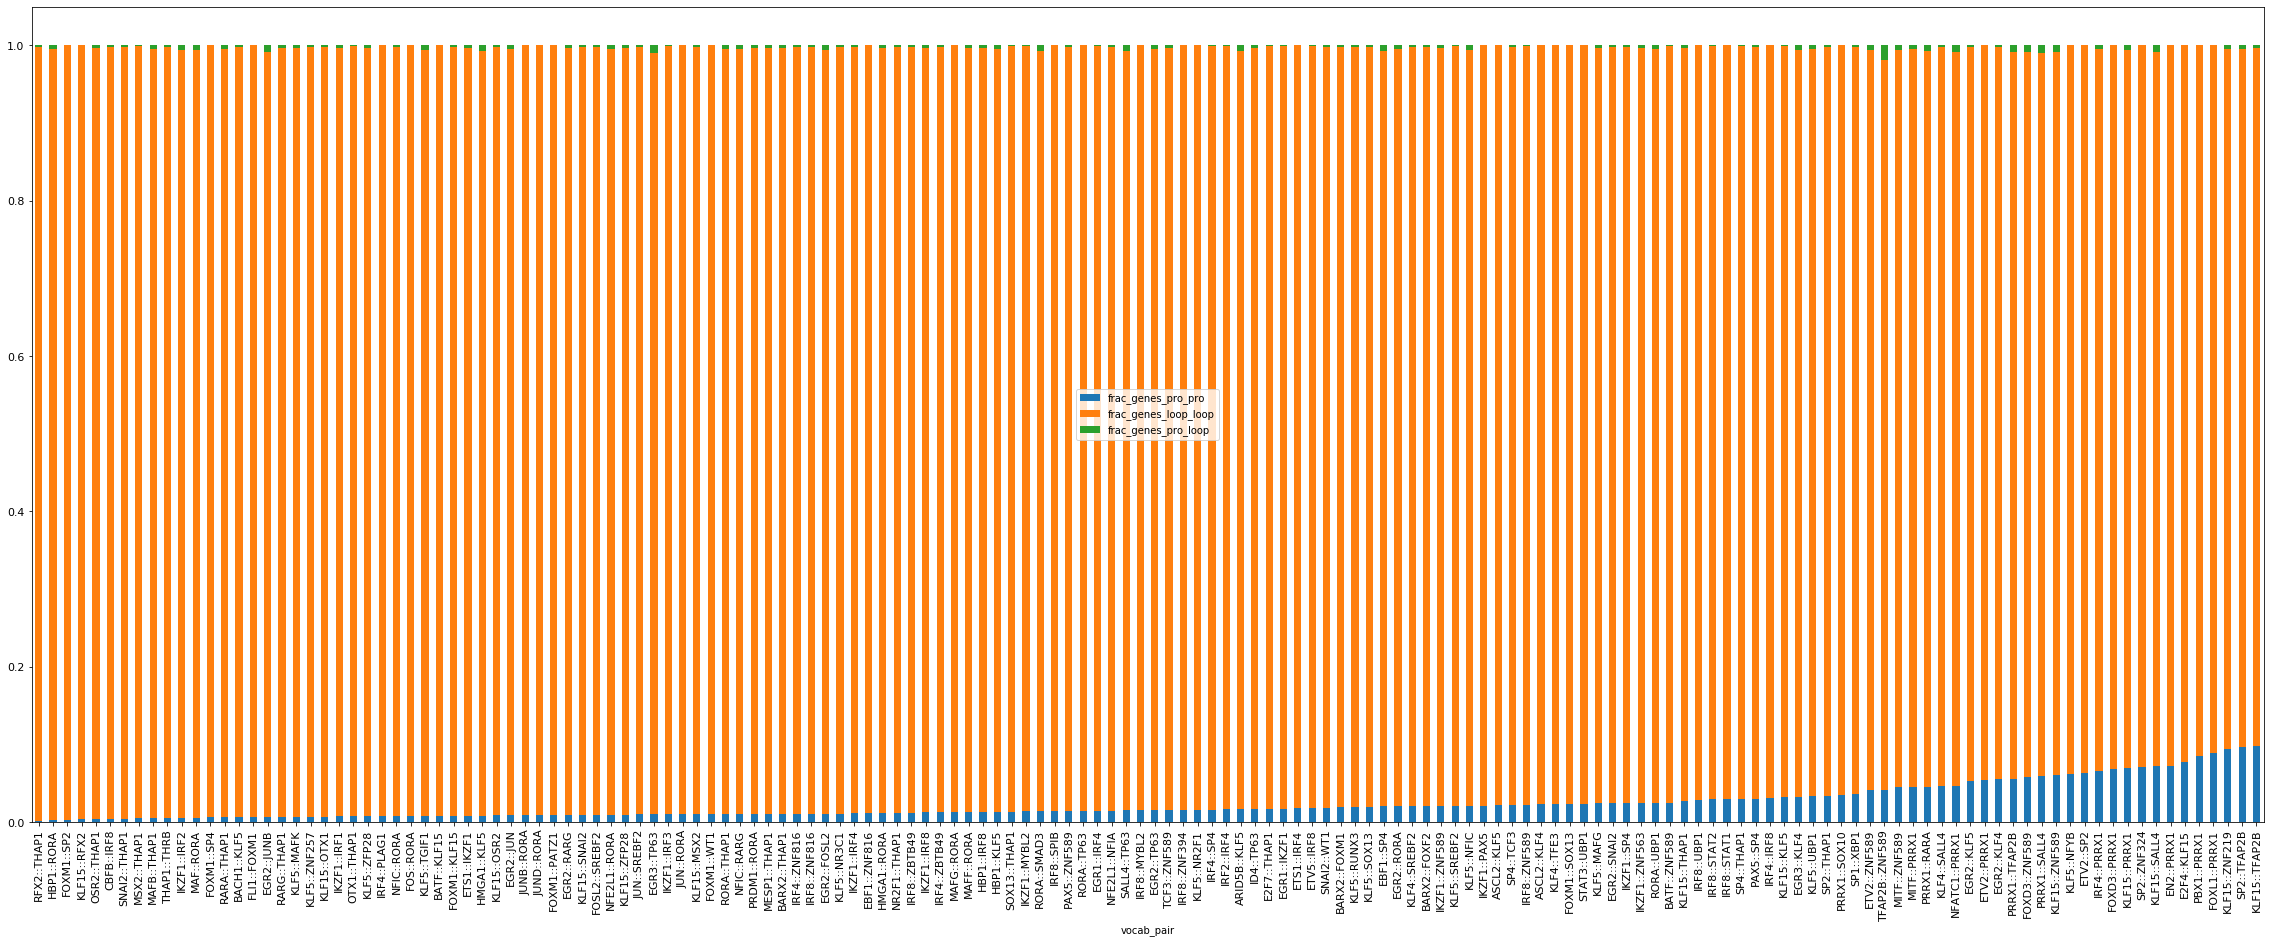

In [128]:
normal_vocab_config_frac = normal_vocab_config_df.set_index('vocab_pair')[['frac_genes_pro_pro','frac_genes_loop_loop','frac_genes_pro_loop']].sort_values('frac_genes_pro_pro')

ax = normal_vocab_config_frac.plot(kind='bar', stacked=True,figsize = (40,15),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'normal_vocab_config_unwt_bar.pdf'))


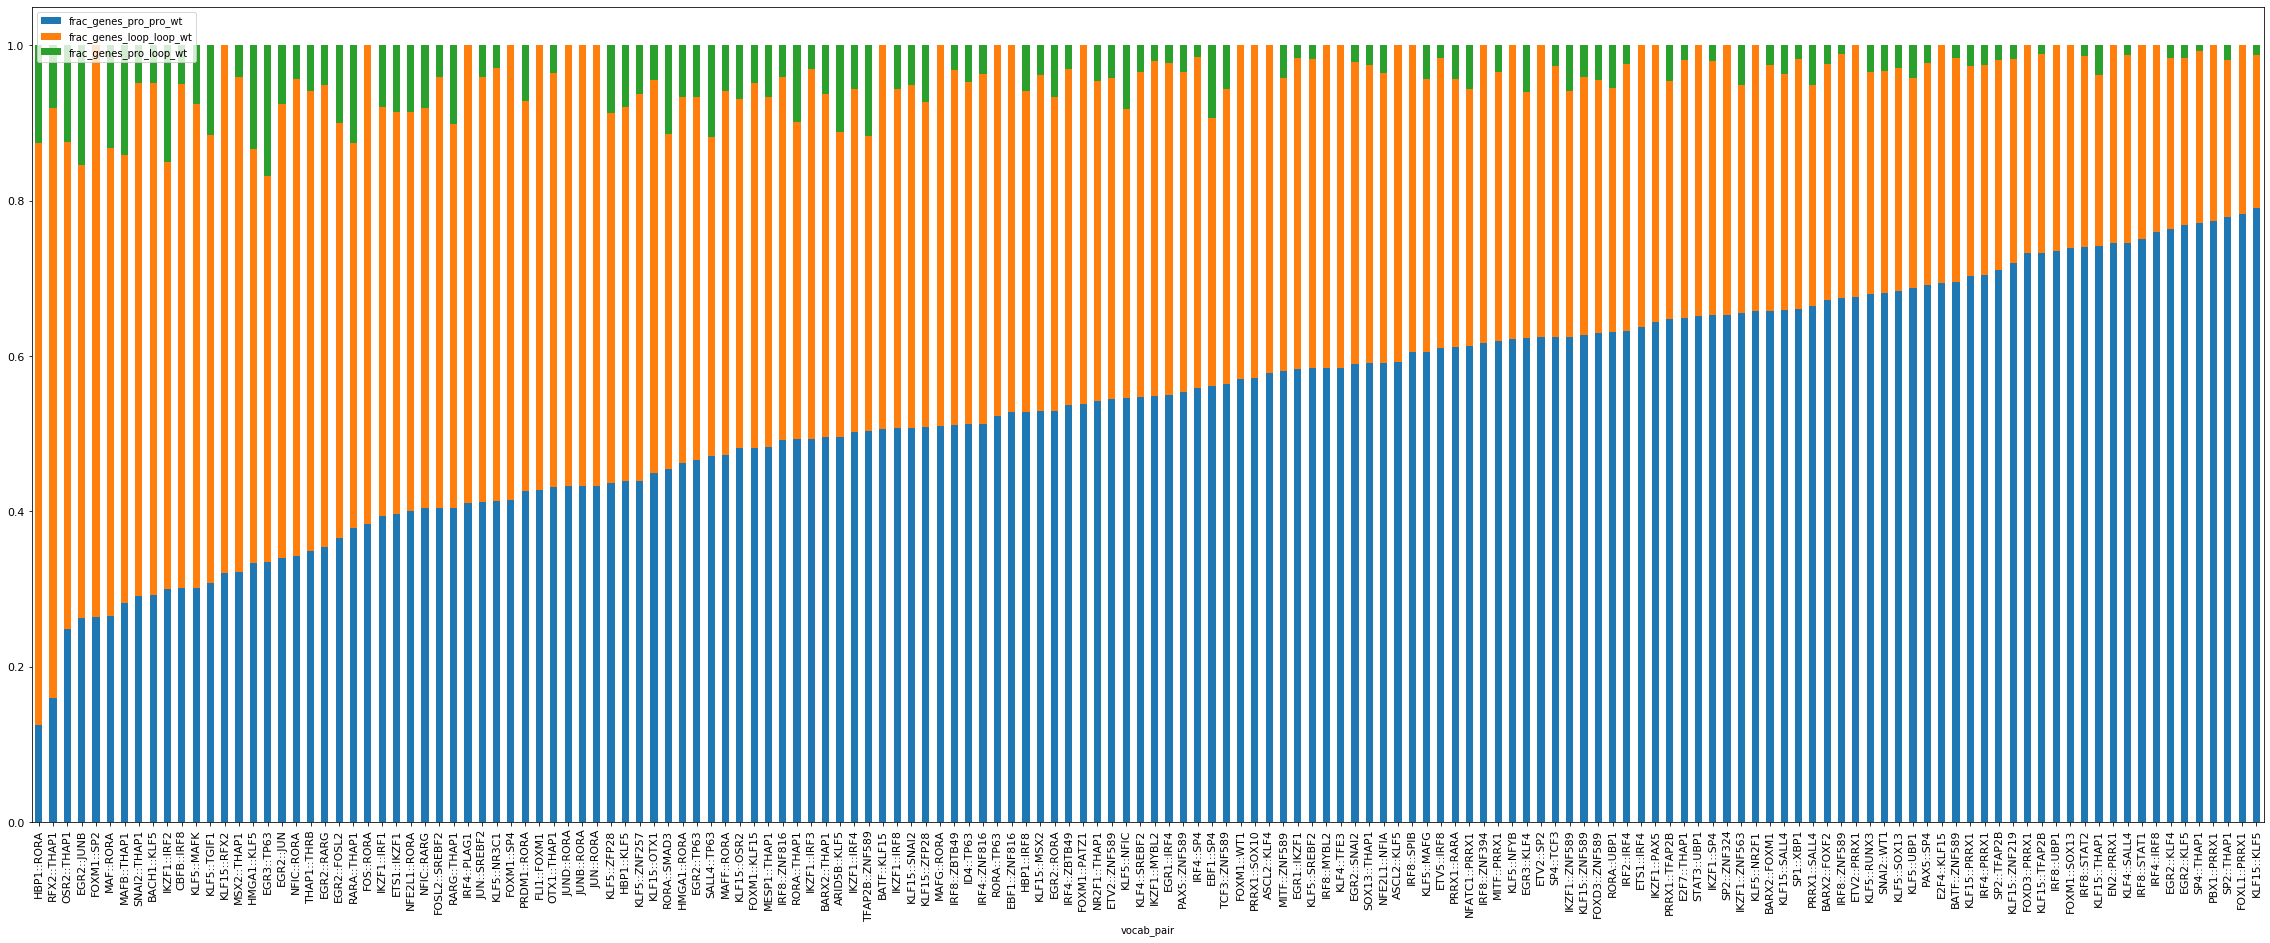

In [129]:
normal_vocab_config_wt = normal_vocab_config_df.set_index('vocab_pair')[['frac_genes_pro_pro_wt','frac_genes_loop_loop_wt','frac_genes_pro_loop_wt']].sort_values('frac_genes_pro_pro_wt')

ax = normal_vocab_config_wt.plot(kind='bar', stacked=True,figsize = (40,15),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'normal_vocab_config_wt_bar.pdf'))


In [110]:
normal_vocab_config_wt

,frac_genes_pro_pro_wt,frac_genes_loop_loop_wt,frac_genes_pro_loop_wt
vocab_pair,,,
HBP1::RORA,0.125419,0.749162,0.125419
RFX2::THAP1,0.159885,0.760172,0.079943
OSR2::THAP1,0.249102,0.626347,0.124551
EGR2::JUNB,0.262935,0.583686,0.153379
FOXM1::SP2,0.264263,0.735737,0.000000
...,...,...,...
SP4::THAP1,0.770832,0.222286,0.006882
PBX1::PRRX1,0.773327,0.226673,0.000000
SP2::THAP1,0.779057,0.202684,0.018259


In [ ]:
# fig,ax= plt.subplots(figsize = (20,7))
# ax.set_xlabel('xlabel', fontsize=6)


# ax.figure.savefig(os.path.join(save_dir, TISSUE+'_pro_count_norm_bar.pdf'))


# Cancer

In [51]:
cancer_vocab_df = mpra_lib_df[mpra_lib_df.tissue.isin(cancer_tissues)][['vocab_pair','tissue']].drop_duplicates().reset_index(drop=True).reset_index()
cancer_vocab_df[['vocab1','vocab2']] = normal_vocab_df.vocab_pair.str.split('::',expand=True)
cancer_vocab_df.to_csv(os.path.join(save_dir, 'cancer_vocab_df.csv'))
cancer_vocab_df[:5]

,index,vocab_pair,tissue,vocab1,vocab2
0,0,ARNT::SP1,SCC,BARX2,FOXF2
1,1,E2F1::SP1,SCC,BARX2,FOXM1
2,2,E2F3::TP63,SCC,BARX2,THAP1
3,3,E2F6::SP1,SCC,BATF,KLF15
4,4,EGR1::SP1,SCC,E2F7,THAP1


In [55]:
tissue_to_geneset_cancer = defaultdict(list)
for idx, row in cancer_vocab_df.iterrows():
    data_all_sel = tissue_to_data_sel[row['tissue']]
    genes_sel = sorted(set(data_all_sel[(data_all_sel[row['vocab1']]>0) & (data_all_sel[row['vocab2']]>0)& (data_all_sel.exp>1)].index))
    print(row['vocab_pair'],row['tissue'],len(genes_sel))
    tissue_to_geneset_cancer[row['tissue']]+=genes_sel
    pd.Series(genes_sel).to_csv(os.path.join(save_dir, 'vocab_genesets', 
                                             row['tissue']+'_'+row['vocab1'] + '-' + row['vocab2']+'.txt'),
                               index=False, header=False)

ARNT::SP1 SCC 0
E2F1::SP1 SCC 0
E2F3::TP63 SCC 775
E2F6::SP1 SCC 0
EGR1::SP1 SCC 1020
EGR1::SP3 SCC 0
ETS1::SP1 SCC 0
IRX3::TP63 SCC 480
KLF16::SP1 SCC 493
KLF16::SP3 SCC 479
KLF16::TFAP2C SCC 480
KLF4::KLF5 SCC 0
KLF4::SP1 SCC 0
KLF4::SP3 SCC 0
KLF4::TFAP2C SCC 0
KLF5::SP3 SCC 0
KLF5::TFAP2C SCC 0
KLF5::ZNF219 SCC 0
KLF6::SP1 SCC 0
MAZ::SP1 SCC 0
NFAT5::SP1 SCC 1301
NR2F1::SP1 SCC 746
NRF1::SP1 SCC 1562
PURA::SP1 SCC 0
SNAI2::SP1 SCC 0
SP1::SP2 SCC 794
SP1::SP3 SCC 1003
SP1::SP4 SCC 517
SP1::TBX1 SCC 1557
SP1::TCF3 SCC 1114
SP1::TFAP2C SCC 859
SP1::TFDP1 SCC 539
SP1::VEZF1 SCC 1110
SP1::ZBTB14 SCC 1091
SP1::ZBTB17 SCC 831
SP1::ZNF219 SCC 525
SP1::ZNF770 SCC 949
SP3::TFAP2C SCC 568
SP3::ZBTB17 SCC 1305
SP3::ZNF219 SCC 1294
TFAP2C::ZBTB14 SCC 1291
TFAP2C::ZNF219 SCC 724
ZFX::E2F6 SCC 1539
ARID5B::LEF1 MM 0
ARID5B::NFE2L1 MM 0
ARID5B::SOX10 MM 104
ARID5B::STAT1 MM 374
EGR2::NFE2L1 MM 366
EGR2::SOX10 MM 313
EGR2::STAT1 MM 0
EGR4::NFE2L1 MM 0
EN2::NFE2L1 MM 395
EN2::STAT1 MM 0
HBP1::STAT1 

In [56]:
for tissue, geneset in tissue_to_geneset_cancer.items():
    geneset = sorted(set(geneset))
    print(tissue, len(geneset))
    pd.Series(geneset).to_csv(os.path.join(save_dir,tissue+'_geneset.txt'),index=False, header=False)

SCC 1670
MM 837


## Cancer cells vocab configurations

- pro_pro: # genes where  vocab1 and vocab2 are both present in pro
- pro_loop: # genes where  vocab1 and vocab2 are present in pro XOR loop but not both
- loop_loop: # genes where  vocab1 and vocab2 are both present in loop but are not in either of the other configurations

In [112]:
cancer_vocab_config_df = pd.DataFrame()
cancer_vocab_config_df['tissue'] = ''
cancer_vocab_config_df['vocab_pair']= ''
cancer_vocab_config_df['genes_pro_pro']= ''
cancer_vocab_config_df['genes_loop_loop']= ''
cancer_vocab_config_df['genes_pro_loop']= ''
cancer_vocab_config_df['genes_all_config']= ''
cancer_vocab_config_df['weighting_factor'] = 1.0

In [115]:
# %%time
for idx, row in cancer_vocab_df.iterrows():
    data_all_sel = tissue_to_data_comb_sel[row['tissue']]
    data_all_sel = data_all_sel[data_all_sel.exp>1]# expression filter
    

    vocab1_pro_col = row['vocab1'] + '_pro'
    vocab1_loop_col = row['vocab1'] + '_loop'
    vocab2_pro_col = row['vocab2'] + '_pro'
    vocab2_loop_col = row['vocab2'] + '_loop'

    weighting_factor = data_all_sel[[vocab1_loop_col,vocab2_loop_col]].sum().sum()/data_all_sel[[vocab1_pro_col,vocab2_pro_col]].sum().sum()

    genes_pro_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]>0)].index)
    genes_loop_loop = set(data_all_sel[(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_loop = genes_loop_loop - genes_pro_pro
    
    genes_pro_loop = set(data_all_sel[(data_all_sel[vocab1_pro_col]>0)&(data_all_sel[vocab2_pro_col]==0)&(data_all_sel[vocab1_loop_col]<=0)&(data_all_sel[vocab2_loop_col]>0)].index)
    genes_loop_pro = set(data_all_sel[(data_all_sel[vocab1_pro_col]==0)&(data_all_sel[vocab2_pro_col]>0)&(data_all_sel[vocab1_loop_col]>0)&(data_all_sel[vocab2_loop_col]<=0)].index)
    genes_pro_loop = genes_pro_loop.union(genes_loop_pro)
                                      
    genes_all_config = genes_pro_pro.union(genes_loop_loop).union(genes_pro_loop)
                                      
    cancer_vocab_config_df.at[idx,'tissue'] = row['tissue']
    cancer_vocab_config_df.at[idx,'vocab_pair']= row['vocab_pair']
    cancer_vocab_config_df.at[idx,'weighting_factor'] = weighting_factor
    cancer_vocab_config_df.at[idx,'genes_pro_pro']= genes_pro_pro
    cancer_vocab_config_df.at[idx,'genes_loop_loop']= genes_loop_loop
    cancer_vocab_config_df.at[idx,'genes_pro_loop']= genes_pro_loop
    cancer_vocab_config_df.at[idx,'genes_all_config']= genes_all_config

    #     print(row['vocab_pair'],row['tissue'],len(genes_sel))
cancer_vocab_config_df['num_genes_pro_pro'] = cancer_vocab_config_df['genes_pro_pro'].map(len)
cancer_vocab_config_df['num_genes_loop_loop']   = cancer_vocab_config_df['genes_loop_loop'].map(len) 
cancer_vocab_config_df['num_genes_pro_loop'] = cancer_vocab_config_df['genes_pro_loop'].map(len)
cancer_vocab_config_df['num_genes_all_config'] = cancer_vocab_config_df['genes_all_config'].map(len)

cancer_vocab_config_df['frac_genes_pro_pro'] = cancer_vocab_config_df['num_genes_pro_pro']/cancer_vocab_config_df['num_genes_all_config']
cancer_vocab_config_df['frac_genes_loop_loop'] = cancer_vocab_config_df['num_genes_loop_loop']/cancer_vocab_config_df['num_genes_all_config']
cancer_vocab_config_df['frac_genes_pro_loop'] = cancer_vocab_config_df['num_genes_pro_loop']/cancer_vocab_config_df['num_genes_all_config']

cancer_vocab_config_df['frac_genes_pro_pro_wt'] = cancer_vocab_config_df['num_genes_pro_pro']*2*cancer_vocab_config_df['weighting_factor']
cancer_vocab_config_df['frac_genes_loop_loop_wt'] = cancer_vocab_config_df['num_genes_loop_loop']
cancer_vocab_config_df['frac_genes_pro_loop_wt'] = cancer_vocab_config_df['num_genes_pro_loop']*cancer_vocab_config_df['weighting_factor']
cancer_vocab_config_df['num_genes_all_config_wt'] = cancer_vocab_config_df['frac_genes_pro_pro_wt'] + cancer_vocab_config_df['frac_genes_loop_loop_wt'] + cancer_vocab_config_df['frac_genes_pro_loop_wt']
cancer_vocab_config_df['frac_genes_pro_pro_wt'] = cancer_vocab_config_df['frac_genes_pro_pro_wt']/cancer_vocab_config_df['num_genes_all_config_wt']
cancer_vocab_config_df['frac_genes_loop_loop_wt'] = cancer_vocab_config_df['frac_genes_loop_loop_wt']/cancer_vocab_config_df['num_genes_all_config_wt']
cancer_vocab_config_df['frac_genes_pro_loop_wt'] = cancer_vocab_config_df['frac_genes_pro_loop_wt']/cancer_vocab_config_df['num_genes_all_config_wt']
 
                             
                                      

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [107]:
cancer_vocab_config_df.to_csv(os.path.join(save_dir, 'cancer_vocab_config_df.csv'))

In [124]:
cancer_vocab_config_df_filt = cancer_vocab_config_df[cancer_vocab_config_df.num_genes_all_config>0]

In [123]:
data_all_sel['SP1_pro'].sum()

1092.0

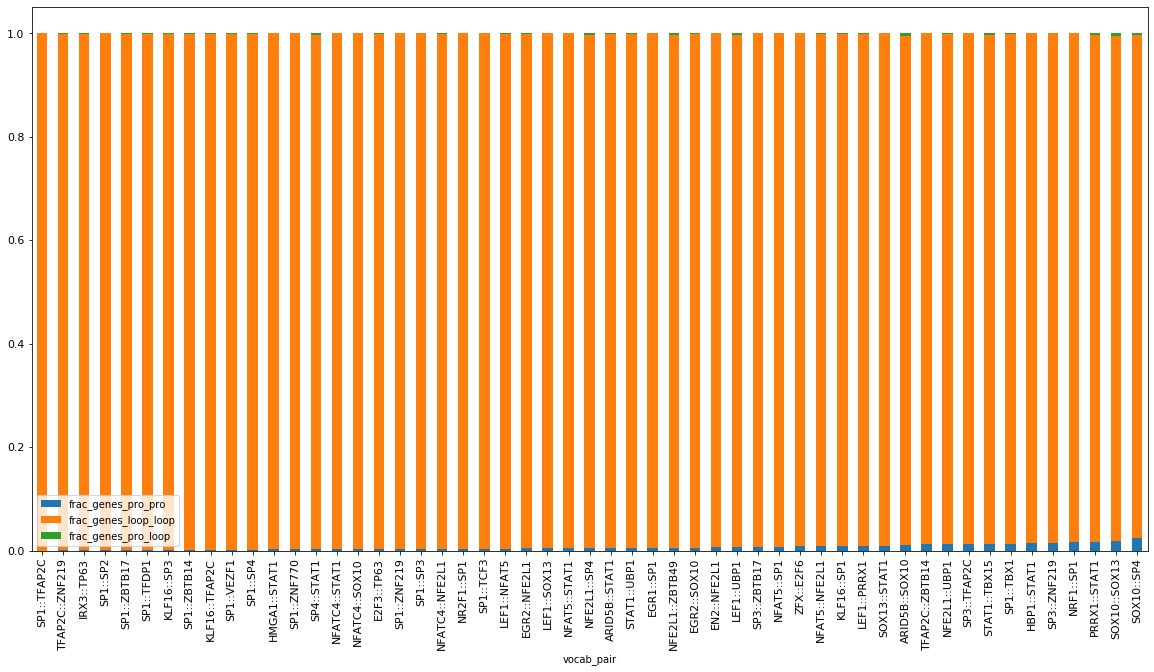

In [125]:
cancer_vocab_config_frac = cancer_vocab_config_df_filt.set_index('vocab_pair')[['frac_genes_pro_pro','frac_genes_loop_loop','frac_genes_pro_loop']].sort_values('frac_genes_pro_pro')

ax = cancer_vocab_config_frac.plot(kind='bar', stacked=True,figsize = (20,10),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'cancer_vocab_config_unwt_bar.pdf'))


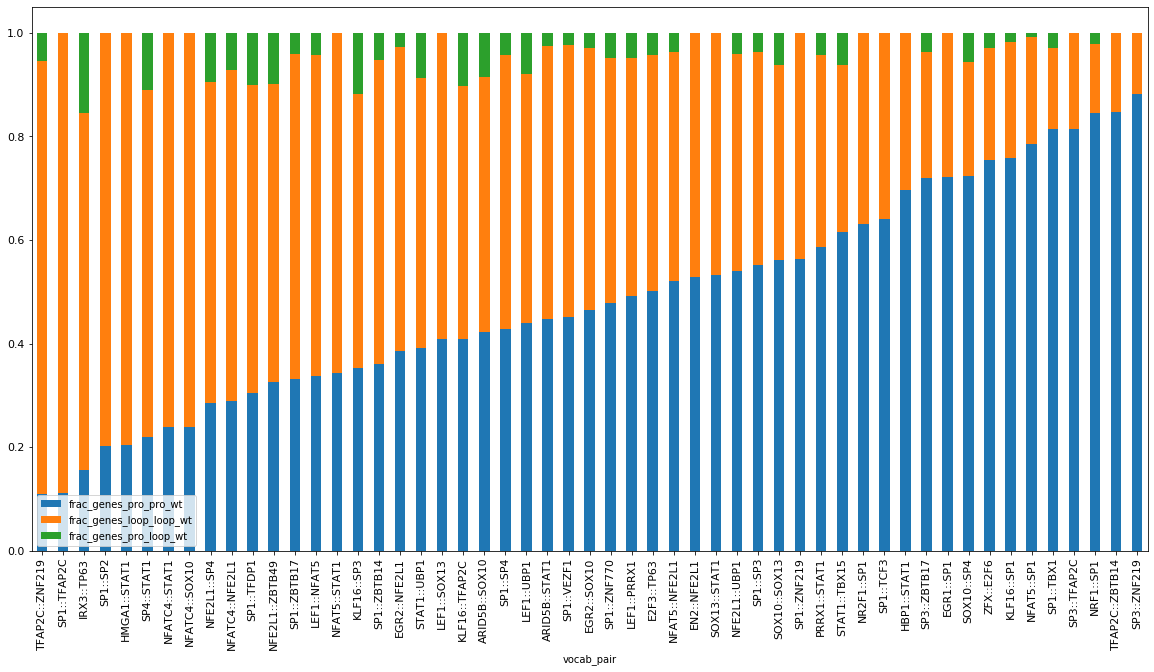

In [130]:
cancer_vocab_config_wt = cancer_vocab_config_df_filt.set_index('vocab_pair')[['frac_genes_pro_pro_wt','frac_genes_loop_loop_wt','frac_genes_pro_loop_wt']].sort_values('frac_genes_pro_pro_wt')

ax = cancer_vocab_config_wt.plot(kind='bar', stacked=True,figsize = (20,10),fontsize=11)
                                                                                                    
ax.figure.savefig(os.path.join(save_dir, 'cancer_vocab_config_wt_bar.pdf'))
